In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests                                    # For API requests
import json                                        # For API requests format wrangling
import time                                        # To delay API & web scrapping pulls to avoid crashes
from tqdm import tqdm                              # to monitor progress of loop

from scipy.stats import chi2_contingency           # Modules necessary for computing statistical tests
from scipy.stats import chi2
from scipy import stats

pd.options.display.max_rows = 4000
pd.set_option('display.max_columns', 100)

# Importing and Preprocessing

In [2]:
# read in the df
links = pd.read_csv('./MovieLens_Data_100k/links.csv')
movies = pd.read_csv('./MovieLens_Data_100k/movies.csv')
ratings = pd.read_csv('./MovieLens_Data_100k/ratings.csv')
tags = pd.read_csv('./MovieLens_Data_100k/tags.csv')

In [3]:
ratings = ratings.drop('timestamp', axis=1)

In [4]:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# define function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
                
                
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

In [5]:
genre_count = pd.DataFrame(keyword_occurences, columns = ['genre', 'count'])
genre_count = pd.DataFrame(keyword_occurences, columns = ['genre', 'count'], index = genre_count.genre)

In [6]:
genre_count.head()

,genre,count
genre,,
Drama,Drama,4361
Comedy,Comedy,3756
Thriller,Thriller,1894
Action,Action,1828
Romance,Romance,1596


<Figure size 432x288 with 0 Axes>

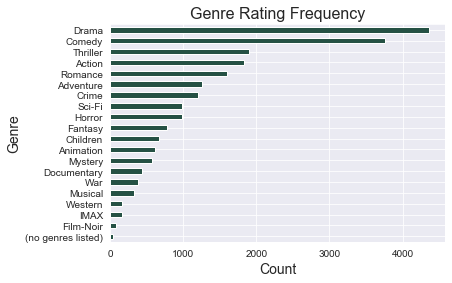

In [7]:
fig, ax = plt.subplots(0)
sns.set_style('darkgrid')
ax = genre_count.sort_values(by='count').plot(kind='barh', legend=False, color='#255144')
ax.set_ylabel('Genre',fontsize=14)
ax.set_xlabel('Count', fontsize=14)
ax.set_title('Genre Rating Frequency', fontsize=16)
plt.savefig('./MovieLens_Data_100k/genre_rating_freq.png', dpi=200)
plt.show()

We can see in the visualization above that the genres with most count of ratings are Drama, Comedy, Thriller and Action. Based on this subset of data alone, these counts may just pose a rating selection effect on neighborhood models since most movies are rated in these categories.

In [8]:
ratings_count = ratings['rating'].value_counts().sort_index(ascending=False)

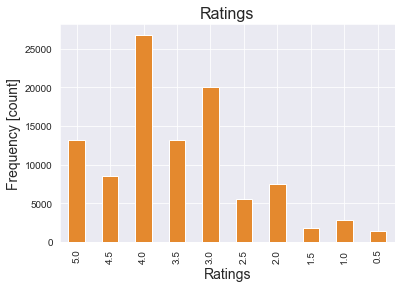

In [9]:
fig, ax = plt.subplots()
sns.set_style('darkgrid')
ax = ratings_count.plot(kind="bar", color='#e4892e')
ax.set_ylabel('Frequency [count]',fontsize=14 )
ax.set_xlabel('Ratings', fontsize=14)
ax.set_title('Ratings', fontsize=16)
plt.savefig('./MovieLens_Data_100k/ratings_freq.png', dpi=200)
plt.show()

We can see that from the distribution of ratings in this data, the most common rating is a 4.0. This might indicate that most movies in this set are truthfully highly rated or possibly suggest user neutrality around this rating. The interpretation here may also have some effect as far as the a personalized recommendation.

In [10]:
ratings.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [11]:
mv_ratings = ratings.merge(movies, on='movieId', how = 'inner')
mv_ratings.drop(columns=['title', 'genres'], inplace = True)

In [12]:
imdb = links['imdbId'].values.astype(str)

In [13]:
# Define function to correct the format of the IMDB ID's included with dataset (need in order to do correct API pull)
def correct_imdb_ids(imdb):  
    imdb_ids = []
    for ids in imdb:
        if len(ids) == 3:
            imdb_ids.append('tt0000'+ids)
        elif len(ids) == 4:
            imdb_ids.append('tt000'+ids)
        elif len(ids) == 5:
            imdb_ids.append('tt00'+ids)
        elif len(ids) == 6:
            imdb_ids.append('tt0'+ids)
        elif len(ids) == 7:
            imdb_ids.append('tt'+ids)   
    return imdb_ids    

In [14]:
imdb_ids = correct_imdb_ids(imdb)  #tested function to see if it worked properly
imdb_ids[:5]

['tt0114709', 'tt0113497', 'tt0113228', 'tt0114885', 'tt0113041']

In [15]:
len(imdb_ids)

9742

In [16]:
# api_key = 'xxxxxxxxxxxxxxx'

In [18]:
# source imdb data for rated movies.
imdb_data = []
for ids in tqdm(imdb_ids):
    request = requests.get('https://api.themoviedb.org/3/movie/' + ids + '?api_key=' + api_key + '&language=en-US')
    time.sleep(.200)
    i = request.json()
    imdb_data.append(i)
print(imdb_data)

# Write collected data to avoid future API calls.
#imdb_data.to_csv('./MovieLens_Data_100k/total_mdb.csv')

100%|██████████| 9742/9742 [1:27:19<00:00,  1.86it/s]     
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
total_mdb = pd.read_csv('./MovieLens_Data_100k/total_mdb.csv')
total_mdb.head()

,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,success,status_code,status_message
0,0,False,/lxD5ak7BOoinRNehOCA85CQ8ubr.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",59.243,/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg,"[{'id': 3, 'logo_path': '/1TjvGVDMYsj6JBxOAkUH...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.9,12892.0,NaN,NaN,NaN
1,1,False,/y7SQmjlB42VvYyRIFQXLQ4ZYrn.jpg,"{'id': 495527, 'name': 'Jumanji Collection', '...",65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://www.sonypictures.com/movies/jumanji/,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,10.067,/bdHG5Mo83VPobeZZdlSz0Y7HQHB.jpg,"[{'id': 559, 'logo_path': '/eC0bWHVjnjUducyA6Y...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,7.2,7534.0,NaN,NaN,NaN
2,2,False,/1J4Z7VhdAgtdd97nCxY7dcBpjGT.jpg,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.425,/1FSXpj5e8l4KH6nVFO5SPUeraOt.jpg,"[{'id': 19464, 'logo_path': None, 'name': 'Lan...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.6,208.0,NaN,NaN,NaN
3,3,False,/yibpm3qFap62p92GL2mP71cevS9.jpg,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",7.669,/4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg,"[{'id': 25, 'logo_path': '/qZCc1lty5FzX30aOCVR...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.2,78.0,NaN,NaN,NaN
4,4,False,/wKQlgHjJwh5mGBZ37vDsXBx9zbh.jpg,"{'id': 96871, 'name': 'Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,13.231,/lf9RTErt8BSLQy98aSFblElvsCQ.jpg,"[{'id': 9195, 'logo_path': '/ou5BUbtulr6tIt699...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-08,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,6.2,431.0,NaN,NaN,NaN


In [17]:
# merge movies and links data
links['imdb_id'] = imdb_ids

In [18]:
mv_ratings = ratings.merge(movies, on = 'movieId', how ='inner')  #merging the movie and rating Data Frames
mv_ratings.drop(columns=['genres'], inplace = True)

In [19]:
mv_ratings.head();

In [20]:
# now merge imdb-link list with mv_ratings dataframe
links_mv_df = mv_ratings.merge(links, on = 'movieId', how ='inner') 
links_mv_df.drop(columns=['tmdbId','imdbId'], inplace = True)
links_mv_df.head()

,userId,movieId,rating,title,imdb_id
0,1,1,4.0,Toy Story (1995),tt0114709
1,5,1,4.0,Toy Story (1995),tt0114709
2,7,1,4.5,Toy Story (1995),tt0114709
3,15,1,2.5,Toy Story (1995),tt0114709
4,17,1,4.5,Toy Story (1995),tt0114709


In [21]:
#now final merge with API data -> merge API data with rating data on IMDB ID
complete_df = links_mv_df.merge(total_mdb, on = 'imdb_id', how ='inner')  

#drop extraneous columns
complete_df.drop(columns=['homepage','tagline','backdrop_path','belongs_to_collection', 'original_language','vote_count','status_message',
               'poster_path','adult','id','original_title', 'production_companies', 'production_countries','status_code',
               'overview','spoken_languages','status','title_y','video','vote_average','success'], inplace = True)

In [22]:
# verify new df
complete_df.head();

In [23]:
# verify dtypes in complete df
complete_df.dtypes

userId            int64
movieId           int64
rating          float64
title_x          object
imdb_id          object
Unnamed: 0        int64
budget          float64
genres           object
popularity      float64
release_date     object
revenue         float64
runtime         float64
dtype: object

### Hypothesis Testing

Because this recommendation system is issuing predictions based on predicted ratings, it seemed pertinent to explore the relationship between ratings issued  and other factors in order to contextualize the recommender.

In [24]:
stats.f_oneway(complete_df['budget'][complete_df['rating'] == 0.5],
               complete_df['budget'][complete_df['rating'] == 1.0],
               complete_df['budget'][complete_df['rating'] == 1.5],
               complete_df['budget'][complete_df['rating'] == 2.0],
               complete_df['budget'][complete_df['rating'] == 2.5],
               complete_df['budget'][complete_df['rating'] == 3.0],
               complete_df['budget'][complete_df['rating'] == 3.5],
               complete_df['budget'][complete_df['rating'] == 4.0],
               complete_df['budget'][complete_df['rating'] == 4.5],
               complete_df['budget'][complete_df['rating'] == 5.0])

F_onewayResult(statistic=67.35532859388148, pvalue=2.38160455615462e-124)

H_0: There is no statistically significant difference between the budget of a movie and its movie rating.

H_A: There is not a statistically significant difference between the budget of a movie and its movie rating

Result:

**p << alpha=0.05 : we reject the null hypothesis and conclude there is a statistically significant difference between ratings across production budgets**

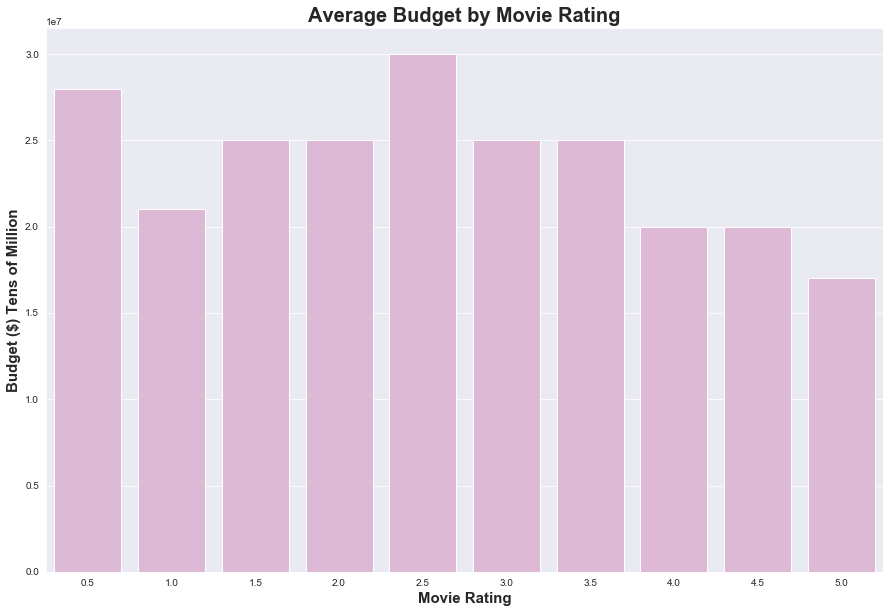

In [25]:
x = complete_df.groupby('rating')['budget'].median().sort_values(ascending = False).keys()
y = complete_df.groupby('rating')['budget'].median().sort_values(ascending = False).values
sns.set_style('darkgrid')
fig,ax=plt.subplots(figsize=(15,10))

sns.barplot(x, y,
           color = '#e3b3d8') #c33d1d - auburn
ax.set_xlabel('Movie Rating',fontweight='bold', fontsize=(15))
ax.set_ylabel('Budget ($) Tens of Million', fontweight='bold', fontsize=(15))
ax.set_title('Average Budget by Movie Rating', fontweight='bold', fontsize=(20))
plt.savefig('./MovieLens_Data_100k/avg_budget_mv_rating.png',dpi=200)

In [30]:
stats.f_oneway(complete_df['runtime'][complete_df['rating'] == 0.5],
               complete_df['runtime'][complete_df['rating'] == 1.0],
               complete_df['runtime'][complete_df['rating'] == 1.5],
               complete_df['runtime'][complete_df['rating'] == 2.0],
               complete_df['runtime'][complete_df['rating'] == 2.5],
               complete_df['runtime'][complete_df['rating'] == 3.0],
               complete_df['runtime'][complete_df['rating'] == 3.5],
               complete_df['runtime'][complete_df['rating'] == 4.0],
               complete_df['runtime'][complete_df['rating'] == 4.5],
               complete_df['runtime'][complete_df['rating'] == 5.0])

F_onewayResult(statistic=251.89013726558713, pvalue=0.0)

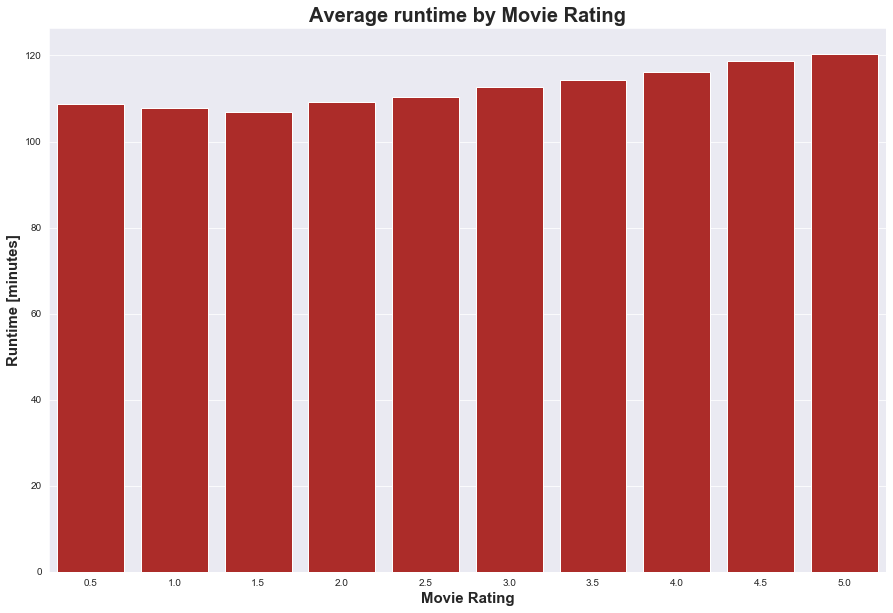

In [30]:
x = complete_df.groupby('rating')['runtime'].mean().sort_values(ascending = False).keys()
y = complete_df.groupby('rating')['runtime'].mean().sort_values(ascending = False).values
sns.set_style('darkgrid')
fig,ax=plt.subplots(figsize=(15,10))

sns.barplot(x, y,
           color = '#c21713') #255144 - dark green
ax.set_xlabel('Movie Rating',fontweight='bold', fontsize=(15))
ax.set_ylabel('Runtime [minutes]', fontweight='bold', fontsize=(15))
ax.set_title('Average runtime by Movie Rating', fontweight='bold', fontsize=(20))
plt.savefig('./MovieLens_Data_100k/avg_runtime_mv_rating.png',dpi=200)

____________________________________

## Building the Models

I chose to use two models to address two approaches in collaborative filtering recommendation engines. These models are KNN which is a Neigborhood-Based method of filtering (making automatic predictions) and SVD which is a model based method. 

**KNN:** 
    KNN is a machine learning algorithm to find clusters of similar users (neighbors) based on common movie ratings, and make predictions using the average rating of top-k nearest neighbors. It uses the weighted-average of the k-most similar neighbors to issue a predicted rating.

**SVD:** 
    SVD is another machine learning algorithm that tries to explain complex relationships between variables in a dataset by decomposing the dataset or matrix and centering on latent relationships much like PCA.
    It is found to be the most accurate approach to reduce problems with sparsity in the data as all users do not rate all movies leading to sparsity in the data. Another useful feature is that SVDs create embeddings (analogous to principle component loadings) which are low-dimensional hidden factors which for a certain user and item coupling can represent exogenous features of the data like how political a movie is, how much special effects it contained and perhaps how dialogue driven the movie is.
    
    
**Evaluation Metrics:**

   For the chosen models, I primarily focused on RMSE as an evaluation metric since I want to evaluate how good the model predicts ratings a given user and movie. A lower RMSE is indicative of improved performance across model runs.

I focus on RMSE over MAE as the main evaluation metric because RMSE penalizes larger errors more than MAE. They are both indifferent to the direction of errors and they are negatively oriented which means lower scores are better.

**A note on the Iterative Process:**

An iterative process was employed  with both the KNN and SVD models. For KNN, I tried several variations of the KNN algorithm using both cosine and pearsons correlation similiarities and tracked the RMSE for improvement across all variations of the KNN. I followed the same process with SVD where we used a gridserach to test the RMSE optimization on various hyperparameters.

**KNN vs SVD:**

| KNN                                 | SVD                                                  |
|-------------------------------------|------------------------------------------------------|
| Complete input data is required     |Creates an abstraction that represents data (like PCs)|
| Does not scale well                 |Scales well|
| Pre-computation not possible        |pre-computation possible|
|Relies on user-itemsimilarity metrics|Relies on matrix factorization|

In [32]:
from surprise import Reader, Dataset
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import BaselineOnly
from surprise.model_selection import train_test_split
from surprise import accuracy

In [33]:
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [34]:
reader = Reader()
data = Dataset.load_from_df(ratings, reader)

In [35]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [36]:
# train-test-split
trainset, testset = train_test_split(data, test_size=.25)

#### Baseline Model

In [37]:
algorithm = BaselineOnly()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
bl_rmse = accuracy.rmse(predictions)
bl_mae = accuracy.mae(predictions)

Estimating biases using als...
RMSE: 0.8704
MAE:  0.6705


This is our first model which are optimizing RMSE against.

#### KNN Basic

In [38]:
algorithm = KNNBasic()
algorithm.fit(trainset)
predictions = algorithm.test(testset)
# check the accuracy using Root Mean Square Error
knnbasic_rmse = accuracy.rmse(predictions)
knnbasic_mae = accuracy.mae(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9444
MAE:  0.7234


#### KNN Baseline

In [39]:
algorithm = KNNBaseline()
algorithm.fit(trainset)
predictions = algorithm.test(testset)
# check the accuracy using Root Mean Square Error
knnbaseline_rmse = accuracy.rmse(predictions)
knnbaseline_mae = accuracy.mae(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8712
MAE:  0.6651


#### SVD GridSearchCV

In [40]:
params = {'n_factors': [20, 50, 100, 130],
         'reg_all': [0.02, 0.05, 0.1],
          "n_epochs": [15, 20, 30]}
g_s_svd = GridSearchCV(SVD ,param_grid=params, n_jobs=-1)
g_s_svd.fit(data)

In [41]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8621739056014454, 'mae': 0.661784282626207}
{'rmse': {'n_factors': 130, 'reg_all': 0.05, 'n_epochs': 30}, 'mae': {'n_factors': 130, 'reg_all': 0.05, 'n_epochs': 30}}


#### SVD

In [42]:
algorithm = SVD(n_factors= 130, reg_all=0.05, n_epochs=30)
algorithm.fit(trainset)
predictions = algorithm.test(testset)
# check the accuracy using Root Mean Square Error
svd_rmse = accuracy.rmse(predictions)
svd_mae = accuracy.mae(predictions)

RMSE: 0.8622
MAE:  0.6616


Why SVD and is this a good evaluation? 
Answer: ...

#### KNN_Basic CV (Pearson)

In [43]:
knn_basic_P = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic_P = cross_validate(knn_basic_P, data, n_jobs=-1)
knn_basic_cv_p_rmse = np.mean(cv_knn_basic_P['test_rmse'])
knn_basic_cv_p_mae = np.mean(cv_knn_basic_P['test_mae'])
print('RMSE: ', knn_basic_cv_p_rmse)
print('MAE: ', knn_basic_cv_p_mae)

RMSE:  0.9722453875784483
MAE:  0.7507187126643012


#### KNN_Basic CV (Cosine)

In [44]:
knn_basic_C = KNNBasic(sim_options={'name':'cosine', 'user_based':True})
cv_knn_basic_C = cross_validate(knn_basic_C, data, n_jobs=-1)
knn_basic_cv_c_rmse = np.mean(cv_knn_basic_C['test_rmse'])
knn_basic_cv_c_mae = np.mean(cv_knn_basic_C['test_mae'])
print('RMSE: ', knn_basic_cv_c_rmse)
print('MAE: ', knn_basic_cv_c_mae)

RMSE:  0.9726934665579485
MAE:  0.7487747840573042


#### KNN_Baseline CV (Pearson)

In [45]:
knn_baseline_P = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline_P = cross_validate(knn_baseline_P,data)
knn_baseline_cv_p_rmse = np.mean(cv_knn_baseline_P['test_rmse'])
knn_baseline_cv_p_mae = np.mean(cv_knn_baseline_P['test_mae'])
print('RMSE: ', knn_baseline_cv_p_rmse)
print('MAE: ', knn_baseline_cv_p_mae)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE:  0.8761322207228535
MAE:  0.6691843479203484


#### KNN_Baseline CV (Cosine)

In [46]:
knn_baseline_C = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline_C = cross_validate(knn_baseline_C,data)
knn_baseline_cv_c_rmse = np.mean(cv_knn_baseline_C['test_rmse'])
knn_baseline_cv_c_mae = np.mean(cv_knn_baseline_C['test_mae'])
print('RMSE: ', knn_baseline_cv_c_rmse)
print('MAE: ', knn_baseline_cv_c_mae)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE:  0.8777478577890205
MAE:  0.670229392418563


### Final Table

In [47]:
scores = {}
scores['KNN_Baseline'] = knnbaseline_rmse, knnbaseline_mae
scores['KNN_Baseline_CV_P'] = knn_baseline_cv_p_rmse, knn_baseline_cv_p_mae
scores['KNN_Baseline_CV_C'] = knn_baseline_cv_c_rmse, knn_baseline_cv_c_mae
scores['KNN_Basic'] = knnbasic_rmse, knnbasic_mae
scores['KNN_Basic_CV_P'] = knn_basic_cv_p_rmse, knn_basic_cv_p_mae
scores['KNN_Basic_CV_C'] = knn_basic_cv_c_rmse, knn_basic_cv_c_mae
scores['Baseline'] = bl_rmse, bl_mae
scores['SVD'] = svd_rmse, svd_mae
scores

{'KNN_Baseline': (0.871191046381951, 0.6651119887464674),
 'KNN_Baseline_CV_P': (0.8761322207228535, 0.6691843479203484),
 'KNN_Baseline_CV_C': (0.8777478577890205, 0.670229392418563),
 'KNN_Basic': (0.944424175174155, 0.7233620303978454),
 'KNN_Basic_CV_P': (0.9722453875784483, 0.7507187126643012),
 'KNN_Basic_CV_C': (0.9726934665579485, 0.7487747840573042),
 'Baseline': (0.8703785105118974, 0.6704810315219211),
 'SVD': (0.8621980334639552, 0.6615799648628669)}

In [48]:
s = pd.DataFrame.from_dict(scores, orient='index',columns = ['RMSE', 'MAE'])
s.index.name = 'Models'
s.sort_values(by = 'RMSE')

,RMSE,MAE
Models,,
SVD,0.862198,0.661580
Baseline,0.870379,0.670481
KNN_Baseline,0.871191,0.665112
KNN_Baseline_CV_P,0.876132,0.669184
KNN_Baseline_CV_C,0.877748,0.670229
KNN_Basic,0.944424,0.723362
KNN_Basic_CV_P,0.972245,0.750719
KNN_Basic_CV_C,0.972693,0.748775


As seen above, best model according to the RMSE, was SVD and the second best was the baseline.

## Build Recommendation System

In [49]:
svd = SVD(n_factors= 130, reg_all=0.05, n_epochs=30)
svd.fit(dataset)

In [50]:
svd.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=2.687584988298126, details={'was_impossible': False})

### Rec's for a new user

assess a new user rating: try your own ratings and see where it goes...

In [61]:
user_rating = [{'userId': 701, 'movieId': 8844, 'rating': '4.5'}, # The Green Mile
 {'userId': 701, 'movieId': 21032, 'rating': '5'},                # Indiana Jones
 {'userId': 701, 'movieId': 9312, 'rating': '4.0'},               # Children of Men
 {'userId': 701, 'movieId': 27793, 'rating': '5.0'}]              # Driver

### Making Predictions with New Rating

In [62]:
## add the new ratings to the original ratings DataFrame
new_ratings_df = ratings.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [63]:
# train a model using the new combined DataFrame
svd_ = SVD(n_factors= 130, reg_all=0.05, n_epochs=30)
svd_.fit(new_data.build_full_trainset())

In [74]:
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
list_of_movies = []
for m_id in ratings['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(701,m_id)[3]))

In [75]:
# order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

**Empirical Evaluation: Test on JP**

We felt it useful to include another evaluation metric and chose to do an empirical evaluation by testing on myself. I appended my submitted ratings record in the ratings table and submitted ratings for 4 movies. In reference to the recommendations given, I had seen 3/5 movies and enjoyed them and hadn't seen the other two.

In [73]:
# return the top n recommendations 
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,10)

Recommendation #  1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  2 :  883    Paths of Glory (1957)
Name: title, dtype: object 

Recommendation #  3 :  680    Philadelphia Story, The (1940)
Name: title, dtype: object 

Recommendation #  4 :  1762    Celebration, The (Festen) (1998)
Name: title, dtype: object 

Recommendation #  5 :  906    Lawrence of Arabia (1962)
Name: title, dtype: object 

Recommendation #  6 :  8466    Whiplash (2014)
Name: title, dtype: object 

Recommendation #  7 :  2226    Fight Club (1999)
Name: title, dtype: object 

Recommendation #  8 :  148    Living in Oblivion (1995)
Name: title, dtype: object 

Recommendation #  9 :  841    Streetcar Named Desire, A (1951)
Name: title, dtype: object 

Recommendation #  10 :  5073    Infernal Affairs (Mou gaan dou) (2002)
Name: title, dtype: object 



## Conclusions & Business Case.

Based on the low RMSE score, and the high success rate from the empirical evaluation (considering film similarity in the action/adventure genre), we can say with fair confidence that our preliminary model works well and is recommending on some similarity. Given an RMSE score of .86 we know that we can say that individual users with benefit from this personalized recommendation system. All the user needs to do is fill in ratings for a few movies from this data set and it will accurately return the indicated number of movie recommendations.

We can market this technology and framework to online streaming services who would benefit greatly from this low RMSE and high empirical evaluation.

## Future Steps
In the future I will build onto this project and add better recommendations. One way we plan on doing this is only recommending movies based on certain genres and year similarity (considering movies in the same time period often have similar production quality and effects) if thats what the user wants to see. Another feature that we would like to add is a non-personalized recommendation system. We will list the top movies based on popularity (number of times rated) from years that the user chooses and only show the movies which they have not yet seen. Also as a continuing exercise i will continue to compose a code framework for a recommnedation system that can be productionized and run on large-volume data sets.





